In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


## Import the required libraries

In [ ]:
"""
Implementation  of "Model-Free Training of E2E Communication Systems"

We try to model the entire Tx-Rx system as a autoencoder which does not require
the channel model to predict the transmitted symbol at the receiver.

Transmitter  : Encoder
Receiver : Decoder

Brief overview of the implementation

Model : Autoencoder
I/p : One-hot encoded vector 'msg'
Encoder o/p : Symbol 'x' obtained from the modulation scheme corresponding to 'msg'
Decoder i/p : Noisy version of the 'x'
Decoder o/p : Predicted Output, m_estimate preceded by a soft-max layer

Encoder : 1st layer: o/p size is same as the size of 'msg', activation : ELU
          2nd layer: o/p size is of the size '2*N' where N is the no. of different
                     symbols used in the modulation scheme, activation : ReLU
          3rd layer: Batch Normalization (To satisty the power characteristics)
          

Decoder : 
                     
                     

"""

#import the required libraries


import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from tensorflow.keras.layers import *
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

<IPython.core.display.Javascript object>

## Define the required helper functions

In [ ]:
#------------------------------AWGN Channel------------------------------------
def AWGN(X, noise_std):
    #Standard deviation is multipleid by (1/sqrt(2)) so that the standard deviation of the complex noise is 1. 
    noise = K.random_normal(K.shape(X),mean = 0, stddev= (noise_std*0.707))
    
    #separate the real and imaginary parts of the noise and the symbol
    noise_r = noise[:,:,0] 
    noise_i = noise[:,:,1]

    X_r = X[:,:,0]
    X_i = X[:,:,1]

    #add the real and imaginary parts of noise and the symbols 
    real = tf.keras.layers.Add()([X_r, noise_r])
    imag = tf.keras.layers.Add()([X_i, noise_i])
    
    #stack the real and imaginary parts along the last axis and return the tensor
    Y = K.stack([real, imag], axis=-1)
    return Y

#------------------------------Perturbation------------------------------------

def perturbation(X):
    sigma = 0.15*0.707 #std deviation used in the paper

    #Standard deviation is multipleid by (1/sqrt(2)) so that the standard deviation of the complex perturbation is 1. 
    noise = K.random_normal(K.shape(X),mean = 0, stddev= (sigma))
    noise_r = noise[:,:,0]
    noise_i = noise[:,:,1]

    X_r = np.sqrt(1-sigma**2) * X[:,:,0] #refer to eq. 11 in the paper
    X_i = np.sqrt(1-sigma**2) * X[:,:,1]
    real = tf.keras.layers.Add()([X_r, noise_r])
    imag = tf.keras.layers.Add()([X_i, noise_i])
    
    Y = K.stack([real, imag], axis=2)
    return Y

#--------------Rayleigh Fading Channel (Rayleigh Block Fading)-----------------
def RBF(X):
   
    #Channel Fading coefficient is multipleid by (1/sqrt(2)) so that the standard deviation of the complex channel fading coefficient is 1. 
    h = 0.707 * K.random_normal(K.shape(X),mean = 0, stddev=1)
    noise = K.random_normal(K.shape(X),mean = 0, stddev = noise_std*0.707)
    noise_r = noise[:,:,0]
    noise_i = noise[:,:,1]
    h_r = h[:,:,0]
    h_i = h[:,:,1]

    X_r = h_r * X[:,:,0] #refer to eq. 11 in the paper
    X_i = h_i * X[:,:,1]

    real = tf.keras.layers.Add()([X_r, noise_r])
    imag = tf.keras.layers.Add()([X_i, noise_i])
    
    Y = K.stack([real, imag], axis=2)
    return Y

def generate_one_hot_vector(M, data_size,get_label= False):
    """
    Generate one hot vectors for training and testing
    M : No. of bits in a message
    data_size : no. of messages to be generated
    """
    M_Oh = 2**M  #dimension of the one-hot message

    #generate random intergers between 0 to M-1 
    eye_matrix = np.eye(M_Oh) #identity matrix of size 2**M
    msgs = np.tile(eye_matrix, (int(data_size/M_Oh),1))  #repeat the generated one-hot vectors
    np.random.shuffle(msgs) #shuffle the messages along the 1st dimension
    
    return msgs 

def BER(y_true, y_pred):
    #Finds the bit error rate
    return K.mean(K.not_equal(y_true, K.round(y_pred)), axis=-1)  

def B_Ber(input_msg, msg):
    '''Calculate the Block Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    # print(pred_error)
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def AvgEngy_Constraint(X):
  X_pseudonorm =  tf.sqrt(tf.reduce_mean( tf.square(X), axis=[1,2],keepdims=True)*2)

  X_normalized = X/X_pseudonorm
  # print(tf.reduce_sum(tf.square(X_normalized), axis = [1,2])) #for cross-checking
  return X_normalized
    

<IPython.core.display.Javascript object>

In [ ]:
# Custom callback to stor the losses for each batch

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        # self.val_losses = []
        self.B_Ber = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.val_losses.append(logs.get('val_loss'))
        self.B_Ber.append(logs.get('B_Ber'))

<IPython.core.display.Javascript object>

## AWGN Channel

#### Model Aware Training

*   In model aware training the weigths of the transmitter and receiver are updated using the backpropagation directly




In [ ]:
%matplotlib inline
#----------------Parameters for the autoencoder-------------------------------------
M = 8  #no. of bits in a message
N = 4 #no. of symbols corresponding to the modulation scheme

SNRdb_train = 10 #SNR in dB for which the model is trained 
SNRWt_train = 10**(SNRdb_train/10) #SNR in watt
noise_std = np.sqrt(1/(2*SNRWt_train))  #std deviation of noise signal

b_size = 20*(2**M) #batch size
n_epoch = 15 #number of epochs
lr = 0.01 #learning rate
train_size = 2500*(2**M) #no. of training examples
test_size = int(train_size*0.1) #no. of test examples


#---------------------------Encoder---------------------------------------
m_ip = keras.Input(shape =(2**M,))  #input to the autoencoder

#two FC layers with 'elu' and 'relu' as the activation functions respectively.
m = tf.keras.layers.Dense(2**M,activation = 'elu', name = 'Tx1')(m_ip)
m= tf.keras.layers.Dense(2*N,activation = None, name = 'Tx2')(m)

#reshape X_hat such that it represents complex symbol
X_reshape = tf.keras.layers.Reshape((-1,2))(m) #Tx symbol

#we need to have a custom layer for normalization. Hence we use Lambda layer
#to define our own function of the custom layer.
# X = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=-1))(X_reshape)  #using this is giving very low accuracy
X = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(tf.reduce_mean(tf.square(x))*2)) (X_reshape)  #is this correct
# X = tf.keras.layers.Lambda(lambda x : AvgEngy_Constraint(x))(X_reshape)  # This doen't give the correct constellation diagram

encoder_NoAL = keras.Model(m_ip,X)
encoder_NoAL.summary()
 
#--------------------------AWGN Channel---------------------------------------------

#add the noise to the transmitted symbol
# Y = tf.keras.layers.Lambda(lambda x: RBF(x))(X)

#-----------------------------------Decoder------------------------------------------

X_enc = keras.Input(shape=(N,2,))
Y = tf.keras.layers.Flatten()(X_enc)  #flatten the received input 

#two FC layes at receiver with the last layer having 'softmax' as the activation
Y = tf.keras.layers.Dense(2**M, activation= 'relu',name = 'Rx1')(Y)
deco_op = tf.keras.layers.Dense(2**M, activation= 'softmax', name = 'Rx2')(Y)

decoder_NoAL = keras.Model(X_enc, deco_op)
decoder_NoAL.summary()

#------------------------Autoencoder ------------------------------------

#create the autoencoder, encoder and decoder model for training and testing
AE_ip = keras.Input(shape =(2**M,))  #input to the autoencoder
encoded_msg = encoder_NoAL(AE_ip)
rx_enmsg = tf.keras.layers.Lambda(lambda x: AWGN(x, noise_std))(encoded_msg) #received encoded message
decoded_msg = decoder_NoAL(rx_enmsg)

AE_NoAL = keras.Model(AE_ip,decoded_msg)
AE_NoAL.summary()
loss_fn = keras.losses.CategoricalCrossentropy()  #Cross entropy loss as specified in the paper
AE_NoAL.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss = loss_fn, metrics = [B_Ber])

#------------------Genertate the dataset for training----------------------------------------
train_messages = generate_one_hot_vector(M, train_size)
train_data = tf.data.Dataset.from_tensor_slices((train_messages,train_messages))
train_data = train_data.shuffle(buffer_size = 1024).batch(b_size)

#train the autoencoder model
history = LossHistory()
AE_NoAL.fit(train_messages,train_messages,batch_size=b_size,epochs = n_epoch, verbose = 1, callbacks = [history])

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# for i in range(n_epoch):
#     for (x_batch,y_batch) in train_data:
#         with tf.GradientTape() as tape:
#             prediction = AE(x_batch, training = True)
#             loss_value = tf.keras.losses.MSE(y_batch,prediction)
#         grads = tape.gradient(loss_value, AE.trainable_variables)
#         optimizer.apply_gradients(zip(grads, AE.trainable_weights ))
  
# test_messages = generate_one_hot_vector(M, test_size)
# X_test = encoder.predict(test_messages)
# m_hat = AE.predict(test_messages)
# m_hat = m_hat.argmax(axis=1)
# m_oh = tf.one_hot(m_hat,depth = 2**M)
# m_oh = m_oh.numpy()
# m = test_messages.argmax(axis=1)

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 Tx1 (Dense)                 (None, 256)               65792     
                                                                 
 Tx2 (Dense)                 (None, 8)                 2056      
                                                                 
 reshape (Reshape)           (None, 4, 2)              0         
                                                                 
 lambda (Lambda)             (None, 4, 2)              0         
                                                                 
Total params: 67,848
Trainable params: 67,848
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
________________________________________

#### Plot BLER v/s Iterations

<IPython.core.display.Javascript object>

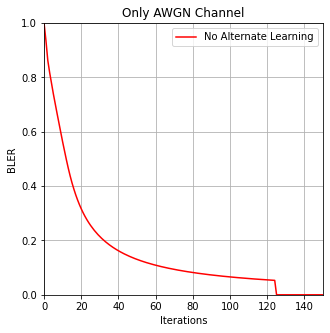

In [ ]:
#plot the BLER v/s Iterations
fig = plt.figure(figsize=(5, 5))
plt.plot(history.B_Ber, 'r-', label ='No Alternate Learning')
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, 150)
# plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('BLER')
plt.title('Only AWGN Channel')
plt.grid(True, which="both")
plt.legend()
plt.show()


#### Observation: (**Need to verfiy this!**)
* There is a sudden decrease in the loss after the 1st epoch.
* This might be because the losses might be averaged over all the previous batches of the same epoch. Hence losses at the end of the epoch will be like averaged loss over all the previous batches. 
* However at the begining of the next epoch the loss of the 1st batch will be very less.

### Testing the model for different SNR's

In [ ]:
test_size = 1e6
#--------------------Plot the BLER v/s SNR plot--------------------------------
SNR_range = list(np.linspace(-2.2,12.8,20))
# BER = [None] * len(SNR_range)
BLER = [None] * len(SNR_range)

print("The variation of BLER with respect to SNR:")
for n in range(0, len(SNR_range)):
    SNR_Wt =10 ** (SNR_range[n]/10)
    noise_std = np.sqrt(1/(2*SNR_Wt))  #std deviation of noise signal
    
    test_messages = generate_one_hot_vector(M, test_size)  #generate the test dataset
    no_errors = 0
    X_hat = encoder_NoAL.predict(test_messages)  #obtain the encoded signal
    Y = AWGN(X_hat, noise_std)   #transmit the encoded signal through the channel
    msg_hat = decoder_NoAL.predict(Y)  #decode the received signal
    
    # msg_hat = AE.predict(test_messages) #this doesn't work (may be because for different SNR's AWGN noise is not changed) 
    msg_hat = msg_hat.argmax(axis = -1)
    
    msg_true = test_messages.argmax(axis = -1)
    no_errors = (msg_hat != msg_true)
    no_errors = np.sum(no_errors)
    
    # m_hat_oh = tf.one_hot(m_hat_oh,depth = 2**M)
    # m_hat_oh = m_hat_oh.numpy()
    # no_errors = (m_hat_oh != test_messages)
    # # print(no_errors[1:3,:])
    # no_errors = np.sum(no_errors,axis=1)
    # no_errors[no_errors>0] = 1
    # # print(np.max(no_errors), 'max')
    # no_errors = no_errors.astype(int).sum() #check this step tomorrow
    # # print(no_errors)
    BLER[n] = no_errors/test_size
    print(" SNR : {:.2f}, BLER : {:.6f}".format(SNR_range[n],BLER[n]))
    # print('SNR:', SNR_range[n], 'BLER', BLER[n])


<IPython.core.display.Javascript object>

The variation of BLER with respect to SNR
 SNR : -2.20, BLER : 0.687489
 SNR : -1.41, BLER : 0.621825
 SNR : -0.62, BLER : 0.547011
 SNR : 0.17, BLER : 0.466429
 SNR : 0.96, BLER : 0.381329
 SNR : 1.75, BLER : 0.296674
 SNR : 2.54, BLER : 0.217971
 SNR : 3.33, BLER : 0.149292
 SNR : 4.12, BLER : 0.094668
 SNR : 4.91, BLER : 0.054776
 SNR : 5.69, BLER : 0.028461
 SNR : 6.48, BLER : 0.013163
 SNR : 7.27, BLER : 0.005587
 SNR : 8.06, BLER : 0.001987
 SNR : 8.85, BLER : 0.000614
 SNR : 9.64, BLER : 0.000175
 SNR : 10.43, BLER : 0.000038
 SNR : 11.22, BLER : 0.000009
 SNR : 12.01, BLER : 0.000003
 SNR : 12.80, BLER : 0.000000


#### Plot the variation of BLER v/s SNR

<IPython.core.display.Javascript object>

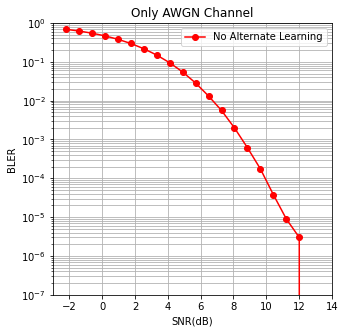

In [ ]:
#plot the BLER v/s SNR
fig = plt.figure(figsize=(5, 5))
plt.semilogy(SNR_range, BLER, 'ro-', label ='No Alternate Learning')
plt.gca().set_ylim(1e-7, 1)
plt.gca().set_xlim(-3, 14)
# plt.yscale('log')
plt.xlabel('SNR(dB)')
plt.ylabel('BLER')
plt.title('Only AWGN Channel')
plt.grid(True, which="both")
plt.legend()
plt.show()

BLER_NoAL = BLER  #store the BLER for different SNR's (useful for the future plots!)

In [ ]:
# train_messages.shape
X_train = np.eye(2**M)
# print(X_train)

X_hat = encoder_NoAL.predict(X_train)  #obtain the encoded signal
Y = AWGN(X_hat, noise_std)   #transmit the encoded signal through the channel
msg_hat = decoder_NoAL.predict(Y)  #decode the received signal

# msg_hat = AE.predict(test_messages) #this doesn't work (may be because for different SNR's AWGN noise is not changed) 
msg_hat = msg_hat.argmax(axis = -1)

print(msg_hat)
    

<IPython.core.display.Javascript object>

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


### Generate the constellation points for each input one-hot vector
###### Observations:
* When M = 2 (No. of bits to be encoded) and N = 1 (only one complex symbol as output) we get the rotated QPSK constellation diagram.
* When M = 4, N = 1 and normalization is done according to energy constraint, we get the rotated 16 PSK.
* When M = 4, N = 1 and normalization is done according to the average-power constraint (i.e., we don't require the norm of the symbols corresponding to each message to obey the power constraint but it's fine if it obeys in expectation (or average). In this case we get the constellation diagram almost similar to concentric circles (but not exactly).

<IPython.core.display.Javascript object>

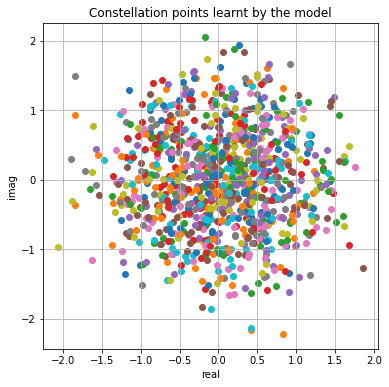

In [ ]:
X_train = np.eye(2**M)
X_hat = encoder_NoAL.predict(X_train)  #obtain the encoded signal
# print(X_hat)
#Here noise_std corresponds to the SNR_range[end] (change it to your required value when required)
Y = AWGN(X_hat, noise_std)   #transmit the encoded signal through the channel
msg_hat = decoder_NoAL.predict(Y)  #decode the received signal
msg_hat = msg_hat.argmax(axis = -1)
# print(f"Ture label : {x.argmax(axis=-1)} and predicted label : {msg_hat}")
# print("The energy constraint, ", tf.reduce_sum(tf.square(X_hat))/(N*k))
plt.figure(figsize=(6, 6))
for i in range(2**M):
  plt.scatter(X_hat[i,:,0],X_hat[i,:,1]) # to plot the encoded symbols
  # plt.scatter(Y[i,:,0],Y[i,:,1])  # to plot the noisy version of the encoded symbols
plt.xlabel('real')
plt.ylabel('imag')
plt.title('Constellation points learnt by the model')
plt.grid(True, which="both")
# plt.legend()
plt.show()

## Model Free End to End Communication with Alternate training

* Here, the receiver and the transmitter are trained alternatively in each epoch 
* The transmitter has a perturbation layer to account for the approximation of the loss function at the transmitter (refer to the paper for detailed explaination)

#### Helper functions

In [ ]:
perturbation_layer = tf.keras.layers.Lambda(lambda x: perturbation(x))
channel_layer = tf.keras.layers.Lambda(lambda x: AWGN(x, noise_std))
loss_object = tf.keras.losses.CategoricalCrossentropy()


def decoder_loss(mb,yb,  validation = False): #mb : messages in batch, yb : labels in batch
  x = encoder_AL(mb)
  y = channel_layer(x, noise_std)
  m_est = decoder_AL(y)
  # if validation == True:
  #   m_hat = tf.math.argmax(m_est, axis=1)
  #   m_hat = m_hat.numpy()
  #   # print("msg_hat : ", m_hat[0:100])
  #   m_argmax = tf.math.argmax(mb, axis=1)
  #   m_argmax = m_argmax.numpy()
  #   # print("msg : ",  m_hat_argmax[0:100])

  #   no_errors = (m_hat != m_argmax)
  #   # print(no_errors[1:3,:])
  #   no_errors = np.sum(no_errors,axis=1)
  #   # no_errors[no_errors>0] = 1
  #   # print(np.max(no_errors), 'max')
  #   # no_errors = no_errors.astype(int).sum() #check this step tomorrow
  #   print(no_errors/test_size)
  return loss_object(yb,m_est), B_Ber(yb,m_est)

def encoder_loss(mb, yb):
  x = encoder_AL(mb)
  x_pb = perturbation_layer(x) #pass the encoder output through the perturbation layer
  y = channel_layer(x_pb, noise_std)
  m_est = decoder_AL(y)


  return loss_object(yb,m_est), B_Ber(yb,m_est) 


<IPython.core.display.Javascript object>

#### ALTERNATE TRAINING

In [ ]:
%matplotlib inline
#----------------Parameters for the autoencoder-------------------------------------
M = 8  #no. of bits in a message
N = 4 #no. of symbols corresponding to the modulation scheme

SNRdb_train = 10 #SNR in dB for which the model is trained 
SNRWt_train = 10**(SNRdb_train/10) #SNR in watt
noise_std = np.sqrt(1/(2*SNRWt_train))  #std deviation of noise signal

b_size = 20*(2**M) #batch size
n_epoch = 15 #number of epochs
lr = 0.01 #learning rate
train_size = 2500*(2**M) #no. of training examples
test_size = int(train_size*0.2) #no. of test examples

#------------------------Autoencoder------------------------------------
 
m_ip = keras.Input(shape =(2**M,))  #input to the autoencoder

#two FC layers with 'relu' as the activation function
m = tf.keras.layers.Dense(2**M,activation = 'elu', name = 'Tx1')(m_ip)
# m = tf.keras.layers.Dense(M*M,activation = 'elu', name = 'Tx11')(m)
m= tf.keras.layers.Dense(2*N,activation = None, name = 'Tx2')(m)

#reshape X_hat such that it represents complex symbol
X_reshape = tf.keras.layers.Reshape((-1,2))(m) #Tx symbol

#we need to have a custom layer for normalization. Hence we use Lambda layer
#to define our own function of the custom layer.
X = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=-1))(X_reshape) #this doesn't help in training the correct model

#is the below line correct? I this yes! because on average the norm by the number of complex symbols should be one but not each sample norm
#reduce_mean will divide the sum by 2*N (no. of terms in each encoded sample) hence we multiply it be 2  
# X = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(tf.reduce_mean(tf.square(x))*2))(X_reshape) 
# X = tf.keras.layers.BatchNormalization()(X)
# X = tf.keras.layers.Lambda(lambda x : AvgEngy_Constraint(x))(X_reshape)  #give loss as 'nan'

encoder_AL = keras.Model(m_ip,X)
encoder_AL.summary()

#add the noise to the transmitted symbol
Y = tf.keras.layers.Lambda(lambda x: AWGN(x, noise_std))(X)
X_enc = keras.Input(shape=(N,2,))
Y = tf.keras.layers.Flatten()(X_enc)
#two FC layes at receiver with the last layer having 'softmax' as the activation
Y = tf.keras.layers.Dense(2**M, activation= 'relu',name = 'Rx1')(Y)
deco_op = tf.keras.layers.Dense(2**M, activation= 'softmax', name = 'Rx2')(Y)

decoder_AL = keras.Model(X_enc, deco_op)
decoder_AL.summary()

#create the autoencoder, encoder and decoder model for training and testing
AE_ip = keras.Input(shape =(2**M,))  #input to the autoencoder
encoded_msg = encoder_AL(AE_ip)
rx_enmsg = tf.keras.layers.Lambda(lambda x: AWGN(x, noise_std))(encoded_msg) # channel_layer(encoded_msg) #received encoded message
decoded_msg = decoder_AL(rx_enmsg)

AE_AL = keras.Model(AE_ip,decoded_msg)
AE_AL.summary()
loss_fn = keras.losses.CategoricalCrossentropy()
AE_AL.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss = loss_fn,  metrics = [B_Ber])

train_messages = generate_one_hot_vector(M, train_size)
train_data = tf.data.Dataset.from_tensor_slices((train_messages,train_messages))
train_data = train_data.shuffle(buffer_size = 256).batch(b_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Tx and Rx training for AWGN channel
#store the accuracy history
BLER_hist_tx = [0]  
BLER_hist_rx = [0]
for i in range(n_epoch):
  train_data_temp = train_data
  for (x_batch,y_batch) in train_data:
    #Rx trianing
      with tf.GradientTape() as tape_rx:
          loss_value, BLER_value_rx = decoder_loss(x_batch,y_batch, validation = False)
      grads = tape_rx.gradient(loss_value, decoder_AL.trainable_variables)
      optimizer.apply_gradients(zip(grads, decoder_AL.trainable_variables ))
      BLER_hist_rx.append(BLER_value_rx)
    #Tx training
  for (x_batch,y_batch) in train_data_temp:
      with tf.GradientTape() as tape_tx:
          loss_value, BLER_value_tx = encoder_loss(x_batch,y_batch)
      grads = tape_tx.gradient(loss_value, encoder_AL.trainable_variables)
      optimizer.apply_gradients(zip(grads, encoder_AL.trainable_variables )) 
      BLER_hist_tx.append(BLER_value_tx)

  test_messages = generate_one_hot_vector(M, test_size)
  val_loss, val_BLER = decoder_loss(test_messages,test_messages, validation = True)
  
  print("Epoch {:d}: Loss: {:.3f}, Training accuracy: {:.3%}, Val_loss: {:.3f}, Validation accuracy: {:.3%}".format(i, loss_value, 1 - BLER_value_rx, val_loss, 1 - val_BLER))

# AE.fit(train_messages,train_messages,batch_size=b_size,epochs = n_epoch, validation_split= 0.1 , verbose = 1)

# X_test = encoder.predict(test_messages)
# m_hat = AE.predict(test_messages)
# m_hat = m_hat.argmax(axis=1)
# m_oh = tf.one_hot(m_hat,depth = 2**M)
# m_oh = m_oh.numpy()
# m = test_messages.argmax(axis=1)

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 Tx1 (Dense)                 (None, 256)               65792     
                                                                 
 Tx2 (Dense)                 (None, 8)                 2056      
                                                                 
 reshape (Reshape)           (None, 4, 2)              0         
                                                                 
 lambda_2 (Lambda)           (None, 4, 2)              0         
                                                                 
Total params: 67,848
Trainable params: 67,848
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
________________________________________

#### Plot B_Ber v/s Iterations

<IPython.core.display.Javascript object>

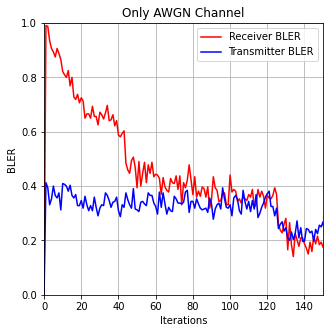

In [ ]:
#plot the BLER v/s Iterations
fig = plt.figure(figsize=(5, 5))
plt.plot(BLER_hist_rx, 'r-', label ='Receiver BLER')
plt.plot(BLER_hist_tx, 'b-', label ='Transmitter BLER')
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, 150)
# plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('BLER')
plt.title('Only AWGN Channel')
plt.grid(True, which="both")
plt.legend()
plt.show()

#### Variation of BLER with respect to SNR for Alternate Training

In [ ]:
# wrap this as a function so can be used for different models

test_size = 1e6
#--------------------Plot the BLER v/s SNR plot--------------------------------
SNR_range = list(np.linspace(-2.2,12.8,20))
# BER = [None] * len(SNR_range)
BLER = [None] * len(SNR_range)

print("Variation of BLER with respect to the SNR:")
for n in range(0, len(SNR_range)):
    SNR =10 ** (SNR_range[n]/10)
    noise_std = np.sqrt(1/(2*SNR))  #std deviation of noise signal
    
    test_messages = generate_one_hot_vector(M, test_size)  #generate the test dataset
    no_errors = 0
    X_hat = encoder_AL.predict(test_messages)  #obtain the encoded signal
    Y = AWGN(X_hat, noise_std)   #transmit the encoded signal through the channel
    msg_hat = decoder_AL.predict(Y)  #decode the received signal
    msg_hat = msg_hat.argmax(axis = -1)

    msg_true = test_messages.argmax(axis = -1)
    no_errors = (msg_hat != msg_true)
    no_errors = np.sum(no_errors)
    
    # m_hat_oh = tf.one_hot(m_hat_oh,depth = 2**M)
    # m_hat_oh = m_hat_oh.numpy()
    # no_errors = (m_hat_oh != test_messages)
    # # print(no_errors[1:3,:])
    # no_errors = np.sum(no_errors,axis=1)
    # no_errors[no_errors>0] = 1
    # # print(np.max(no_errors), 'max')
    # no_errors = no_errors.astype(int).sum() #check this step tomorrow
    # # print(no_errors)
    BLER[n] = no_errors/test_size
    print(" SNR : {:.2f}, BLER : {:.6f}".format(SNR_range[n],BLER[n]))
    # print('SNR:', SNR_range[n], 'BLER', BLER[n])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 SNR : -2.20, BLER : 0.686605
 SNR : -1.41, BLER : 0.618282
 SNR : -0.62, BLER : 0.542339
 SNR : 0.17, BLER : 0.459470
 SNR : 0.96, BLER : 0.373887
 SNR : 1.75, BLER : 0.288835
 SNR : 2.54, BLER : 0.212082
 SNR : 3.33, BLER : 0.146297
 SNR : 4.12, BLER : 0.094446
 SNR : 4.91, BLER : 0.057018
 SNR : 5.69, BLER : 0.032095
 SNR : 6.48, BLER : 0.016685
 SNR : 7.27, BLER : 0.008113
 SNR : 8.06, BLER : 0.003652
 SNR : 8.85, BLER : 0.001585
 SNR : 9.64, BLER : 0.000669
 SNR : 10.43, BLER : 0.000268
 SNR : 11.22, BLER : 0.000127
 SNR : 12.01, BLER : 0.000052
 SNR : 12.80, BLER : 0.000015


#### Plot the variation of BLER w.r.t SNR

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

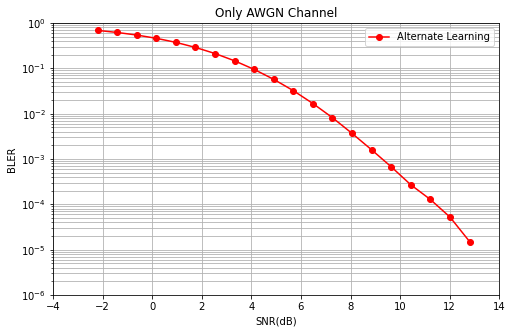

In [ ]:
#plot the BLER v/s SNR
fig = plt.figure(figsize=(8, 5))
plt.semilogy(SNR_range, BLER, 'ro-', label ='Alternate Learning')
plt.gca().set_ylim(1e-6, 1)
plt.gca().set_xlim(-4, 14)
plt.yscale('log')
plt.xlabel('SNR(dB)')
plt.ylabel('BLER')
plt.title('Only AWGN Channel')
plt.grid(True, which="both")
plt.legend()
plt.show()

BLER_AL = BLER  #store the BLER for different SNR's (useful for the future plots!)


#### BLER v/s SNR for both Alternate and No-Alternate Training

In [ ]:
#plot the BLER v/s SNR
fig = plt.figure(figsize=(8, 5))
plt.semilogy(SNR_range, BLER_NoAL, 'bo-', label ='No Alternate Learning')
plt.semilogy(SNR_range, BLER_AL, 'ro-', label ='Alternate Learning')
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(-10, 25)
plt.yscale('log')
plt.xlabel('SNR(dB)')
plt.ylabel('BLER')
plt.title('Only AWGN Channel')
plt.grid(True, which="both")
plt.legend()
plt.show()

# BLER_AL = BLER  #store the BLER for different SNR's (useful for the future plots!)


#### Plot the learned constellation points for all the different inputs

<IPython.core.display.Javascript object>

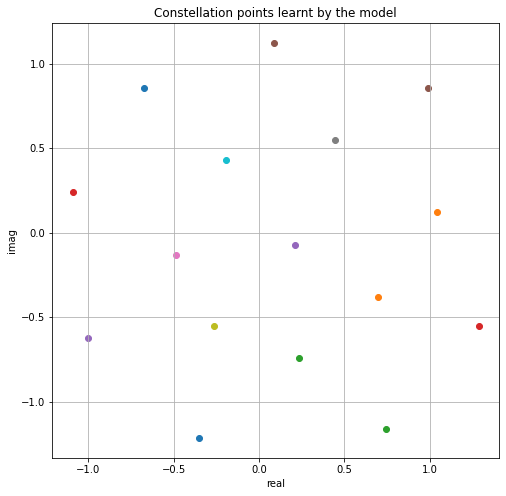

In [ ]:
X_train = np.eye(2**M)
# print(x.shape)
X_hat = encoder_AL.predict(X_train)  #obtain the encoded signal
Y = AWGN(X_hat, noise_std)   #transmit the encoded signal through the channel
msg_hat = decoder_AL.predict(Y)  #decode the received signal
msg_hat = msg_hat.argmax(axis = -1)
# print(f"Ture label : {x.argmax(axis=-1)} and predicted label : {msg_hat}")
# print("The energy constraint, ", tf.reduce_sum(tf.square(X_hat))/(N*k))
plt.figure(figsize=(8, 8))
for i in range(2**M):
  plt.scatter(X_hat[i,:,0],X_hat[i,:,1])
plt.xlabel('real')
plt.ylabel('imag')
plt.title('Constellation points learnt by the model')
plt.grid(True, which="both")
# plt.legend()
plt.show()

## MNIST Image reconstruction over AWGN Channel 
* The reconstruction quality metric used is called as "**Peak-SNR**" which is the inverse of "**Mean Squared Error**".
* N = 10 (channel uses), Batch_size = 128
* SNR during training = 10dB

#### Model Aware Training

In [ ]:
%matplotlib inline
#----------------Parameters for the autoencoder-------------------------------------
N = 10 #no. of symbols corresponding to the modulation scheme

SNRdb_train = 10 #SNR in dB for which the model is trained 
SNRWt_train = 10**(SNRdb_train/10) #SNR in watt
noise_std = np.sqrt(1/(2*SNRWt_train))  #std deviation of noise signal

b_size = 256 #batch size
n_epoch = 2 #number of epochs
lr = 0.001 #learning rate

#------------------Training Data--------------------------------------------------
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

#No. of train and test examples
print(train_images.shape)

#Normalise the pixel values
train_images = train_images/255
test_images = test_images/255
# train_size = 2000 #no. of training examples
# test_size = int(train_size*0.1) #no. of test examples


#---------------------------Encoder---------------------------------------
m_ip = keras.Input(shape =(28,28,1))  #input to the autoencoder

#two FC layers with 'elu' and 'relu' as the activation functions respectively.
m = tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', strides = (1,1))(m_ip)
m= tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides= (2,2))(m)
m= tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides= (2,2))(m)
m = tf.keras.layers.Flatten()(m)
m = tf.keras.layers.Dense(2*N, activation = None)(m)

#reshape X_hat such that it represents complex symbol
X_reshape = tf.keras.layers.Reshape((-1,2))(m) #Tx symbol

#we need to have a custom layer for normalization. Hence we use Lambda layer
#to define our own function of the custom layer.
# X = tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=-1))(X_reshape)  #using this is giving very low accuracy
X = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(tf.reduce_mean(tf.square(x))*2)) (X_reshape)  #is this correct

encoder = keras.Model(m_ip,X)
encoder.summary()
 
#--------------------------AWGN Channel---------------------------------------------

#add the noise to the transmitted symbol
# Y = tf.keras.layers.Lambda(lambda x: RBF(x))(X)

#-----------------------------------Decoder------------------------------------------

X_enc = keras.Input(shape=(N,2))
Y = tf.keras.layers.Flatten()(X_enc)  #flatten the received input 

#two FC layes at receiver with the last layer having 'softmax' as the activation
Y = tf.keras.layers.Dense(3136, activation= 'relu',name = 'Rx1')(Y)
Y = tf.reshape(Y, shape = (-1,7,7,64)) #find a justification for reshaping in this manner
Y = tf.keras.layers.Conv2DTranspose(64, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(Y)
Y = tf.keras.layers.Conv2DTranspose(32, (3,3), activation = 'relu', strides = (2,2), padding = 'same')(Y)
deco_op = tf.keras.layers.Conv2DTranspose(1, (3,3), activation = 'sigmoid', strides = (1,1), padding = 'same')(Y)

decoder = keras.Model(X_enc, deco_op)
decoder.summary()

#------------------------Autoencoder ------------------------------------

#create the autoencoder, encoder and decoder model for training and testing
AE_ip = keras.Input(shape =(28,28))  #input to the autoencoder
encoded_msg = encoder(AE_ip)
rx_enmsg = tf.keras.layers.Lambda(lambda x: AWGN(x, noise_std))(encoded_msg) #received encoded message
decoded_msg = decoder(rx_enmsg)

AE = keras.Model(AE_ip,decoded_msg)
AE.summary()
loss_fn = keras.losses.MeanSquaredError()  #Cross entropy loss as specified in the paper
AE.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss = loss_fn,  metrics = 'acc')

#------------------Genertate the dataset for training----------------------------------------
# train_messages = generate_one_hot_vector(M, train_size)
# train_data = tf.data.Dataset.from_tensor_slices((train_messages,train_messages))
# train_data = train_data.shuffle(buffer_size = 1024).batch(b_size)

#train the autoencoder model
AE.fit(train_images, train_images, batch_size=b_size,epochs = n_epoch, validation_split= 0.1 , verbose = 1)

In [ ]:
# wrap this as a function so can be used for different models

# test_size = 5000
fig = plt.figure(figsize=(20, 100))
N_plt = 17
#--------------------Plot the BLER v/s SNR plot--------------------------------
SNR_range = list(np.linspace(-30,50,N_plt))
# BER = [None] * len(SNR_range)
PSNR_dB = [None] * len(SNR_range)
PSNR_dB = np.array(PSNR_dB)
for n in range(0, len(SNR_range)):
    SNR =10 ** (SNR_range[n]/10)
    noise_std = np.sqrt(1/(2*SNR))  #std deviation of noise signal
    
    # test_messages = generate_one_hot_vector(M, test_size)  #generate the test dataset
    no_errors = 0
    X_hat = encoder.predict(test_images)  #obtain the encoded signal
    Y = AWGN(X_hat, noise_std)   #transmit the encoded signal through the channel
    img_hat = decoder.predict(Y)  #decode the received signal
    img_hat = tf.squeeze(img_hat)
    PSNR = tf.keras.metrics.mean_squared_error(test_images, img_hat )
    PSNR = 1/tf.reduce_mean(PSNR)
    # print(PSNR.shape)
    # msg_true = test_messages.argmax(axis = -1)
    # no_errors = (msg_hat != msg_true)
    # no_errors = np.sum(no_errors)
    
    # m_hat_oh = tf.one_hot(m_hat_oh,depth = 2**M)
    # m_hat_oh = m_hat_oh.numpy()
    # no_errors = (m_hat_oh != test_messages)
    # # print(no_errors[1:3,:])
    # no_errors = np.sum(no_errors,axis=1)
    # no_errors[no_errors>0] = 1
    # # print(np.max(no_errors), 'max')
    # no_errors = no_errors.astype(int).sum() #check this step tomorrow
    # # print(no_errors)
    PSNRdB = 10*np.log10(PSNR)
    PSNR_dB[n] = PSNRdB
    # print(PSNRdB)
    fig.add_subplot(N_plt,2,2*n+1)
    train_imag1=test_images[1][:,:]
    train_imag1=np.array(train_imag1)
    # train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
    plt.imshow(train_imag1, cmap='gray')
    fig.add_subplot(N_plt,2,2*n+2)
    train_imag1=img_hat[1][:,:]
    # print(train_imag1.shape)
    train_imag1=np.array(train_imag1)
    # train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
    plt.imshow(train_imag1, cmap='gray')
    plt.axis('off')
    print("SNR : %.2f" %SNR_range[n], "PSNR %.6f" %PSNRdB)
    # print('SNR:', SNR_range[n], 'BLER', BLER[n])

# #plot the BLER v/s SNR
# fig = plt.figure(figsize=(8, 5))
# plt.plot(SNR_range, PSNR_dB, 'bo-', label ='No Alternate Learning')
# # plt.semilogy(SNR_range, BLER_AL, 'ro-', label ='Alternate Learning')
# plt.gca().set_ylim(0, 50)
# plt.gca().set_xlim(-5, 25)
# plt.yscale('log')
# plt.xlabel('SNR(dB)')
# plt.ylabel('PSNR')
# plt.title('Only AWGN Channel')
# plt.grid(True, which="both")
# plt.legend()
# plt.show()

# PSNR_NoAL = PSNR_dB  #store the BLER for different SNR's (useful for the future plots!)


In [ ]:
#plot the BLER v/s SNR
fig = plt.figure(figsize=(8, 5))
plt.plot(SNR_range, PSNR_dB, 'bo-', label ='No Alternate Learning')
# plt.semilogy(SNR_range, BLER_AL, 'ro-', label ='Alternate Learning')
plt.gca().set_ylim(0, 50)
plt.gca().set_xlim(-30, 50)
# plt.yscale('log')
plt.xlabel('SNR(dB)')
plt.ylabel('PSNR')
plt.title('Only AWGN Channel')
plt.grid(True, which="both")
plt.legend()
plt.show()

PSNR_NoAL = PSNR_dB  #store the BLER for different SNR's (useful for the future plots!)


In [ ]:
K=10
fig = plt.figure(figsize=(20, 10))

for i in range(np.max(K)):
  plt.subplot(2,10,i+1)
  train_imag1=img_hat[i][:,:]
  # print(train_imag1.shape)
  train_imag1=np.array(train_imag1)
  # train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
  plt.imshow(train_imag1)
  plt.axis('off')
  # plt.title("Class "+str(i))

for i in range(np.max(K)):
  plt.subplot(2,10,i+11)
  train_imag1=test_images[i][:,:]
  train_imag1=np.array(train_imag1)
  # train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
  plt.imshow(train_imag1)
  plt.axis('off')
  # plt.title("Class "+str(i))

### Auto-Encoder Model for Rayleigh Block Fading
* For both model-aware and model-free learning two methods were followed:
 
  * Rx with channel-estimation network followed by equalization and decoding. N =5 
  * N = 4 and pilot symbol was used to estimate the channel and rx symbols were equalized.
    



#### Model aware Equalized with N = 5 